In [162]:
#Lib para manipulação de dados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# IO bibliotecas
import os
import csv

# Visualização de progressão para laços
from tqdm import tqdm
import seaborn as sns

# regex
import re

#NLTK — The Natural Language ToolKit is one of the best-known and most-used NLP libraries, 
#useful for all sorts of tasks from tokenization, stemming, tagging, parsing, and beyond
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Remoção de acentos graficos
import unidecode

# Libs para metricas e avaliação
import sklearn.metrics as metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # tf, tf-idf
# Machine learning
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection as ms

#WordCloud

from wordcloud import WordCloud

In [163]:
#Lib para manipulação de dados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# IO bibliotecas
import os
import csv

# Visualização de progressão para laços
from tqdm import tqdm
import seaborn as sns

# regex
import re

#NLTK — The Natural Language ToolKit is one of the best-known and most-used NLP libraries, 
#useful for all sorts of tasks from tokenization, stemming, tagging, parsing, and beyond
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Remoção de acentos graficos
import unidecode

# Libs para metricas e avaliação
import sklearn.metrics as metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # tf, tf-idf
# Machine learning
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection as ms

#WordCloud



In [164]:
# Twetters sobre o estado de minas gerais
twetter_df =  pd.read_csv("./archive/tw_pt.csv")
twetter_df.head()

,Unnamed: 0,Text,Classificacao
0,0,���⛪ @ Catedral de Santo Antônio - Governador ...,Neutro
1,1,"� @ Governador Valadares, Minas Gerais https:/...",Neutro
2,2,"�� @ Governador Valadares, Minas Gerais https:...",Neutro
3,3,��� https://t.co/BnDsO34qK0,Neutro
4,4,��� PSOL vai questionar aumento de vereadores ...,Negativo


# StopWords Remoção
<p> A remoção dos stopWords serve para que o algoritmo de machine learning foque nas frases principais e não nas mais comuns usadas pela lingua <p/>

In [165]:
nltk.download("stopwords")
nltk.download('punkt')

# Configurando para a lingua portuguesa
stop_words = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Breno\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Breno\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [166]:
def removerStopWords(texto):
    #Tokenização
    word_tokens =  word_tokenize(texto)
    
    ps = PorterStemmer()
    
    steamming_words = []
    
    for word in word_tokens:
        steamming_words.append(word)
    
    #Limpa os tokens removendo as stopwords da lingua portuguesa e converte para string, sem o join retorna um array
    sentencas_filtradas =  ' '.join([p for p in word_tokens if not p.lower() in stop_words])         
    
    return sentencas_filtradas.strip()    

In [167]:
def limparTexto(dataFrame):
    result =  pd.DataFrame()
    #Percorrer data linha do data frame
    for row in tqdm(dataFrame.itertuples(index=True, name="Pandas"), desc="Limpar stopWords"):
        Text = row.Text
        Classificacao = row.Classificacao
        
        #Realiza a limpeza de caracteres indesejados no texto.
        
        Text = unidecode.unidecode(Text)
        Text = re.sub(r'http\S+', '', Text)
        Text = removerStopWords(Text)
        Text = Text.replace(" . "," ")
        Text = Text.replace(" , "," ")
        Text = Text.replace(" - "," ")
        Text = Text.replace(" : "," ")
        Text = Text.replace(" @ "," ")
        Text = Text.replace(" # "," ")
        Text = Text.lower().strip()
    
        # Cria um novo dataframe e o concatena ao existente. 
        linha = pd.Series([Text, Classificacao])        
        linha = pd.DataFrame([linha])        
        result = pd.concat([linha, result], ignore_index=True)       
    
    return result

In [168]:
twetter_df_clean =  limparTexto(twetter_df)
twetter_df_clean =  twetter_df_clean.rename(columns= {0: 'Text', 1: "Classificacao"})
twetter_df_clean.head()

Limpar stopWords: 8199it [00:09, 899.89it/s] 


,Text,Classificacao
0,trio suspeito roubo cargas preso santa luzia (...,Positivo
1,trio preso suspeito roubo trafico abuso sexual...,Positivo
2,trio preso suspeito roubo trafico abuso sexual...,Positivo
3,trio preso suspeito roubo trafico abuso sexual...,Positivo
4,trio preso suspeito roubo trafico abuso sexual...,Positivo


# Bag of Words 
#### TF & TF-IDF

In [169]:
bag_of_word = {}
#TF
vectorizer = CountVectorizer()
bag_of_word['tf'] = vectorizer.fit_transform(twetter_df_clean.Text)
bag_of_word['tf'] = bag_of_word['tf'].toarray()

#TF-IDF
vectorizer = TfidfVectorizer()
bag_of_word['tf-idf'] = vectorizer.fit_transform(twetter_df_clean.Text)
bag_of_word['tf-idf'] = bag_of_word['tf-idf'].toarray()

In [170]:
'''
Calcular as métricas de acuracia, precisão, recal, micro e macro f1
'''
def calcularMetricas(dict_metricas, y_test, predict):
    acuracia = metrics.accuracy_score(y_test, predict)
    dict_metricas['acuracia'].append(acuracia)
    
    precision = metrics.precision_score(y_test, predict, average='weighted')
    dict_metricas['precision'].append(precision)
    
    recal = metrics.recall_score(y_test, predict, average='weighted')
    dict_metricas['recal'].append(recal)
    
    micro_f1 = metrics.f1_score(y_test, predict, average='micro')
    dict_metricas['micro_f1'].append(micro_f1)
    
    macro_f1 = metrics.f1_score(y_test, predict, average='macro')
    dict_metricas['macro_f1'].append(macro_f1) 
    
    print(f"----------> PONDERAÇÂO {key}")
    metricas(acuracia, precision, recal, micro_f1, macro_f1)

In [171]:
'''
Printar as métricas
'''
def metricas(acuracia, precision,recal, micro_f1, macro_f1):
    print(f'Acurácia: %.2f' % (acuracia*100))
    print(f'precision: %.2f' % (precision*100))
    print(f'recal: %.2f' % (recal*100))
    print(f'micro-f1: %.2f' % (micro_f1*100))
    print(f'macro-f1: %.2f' % (macro_f1*100))

# Naive Bayes

In [172]:
df_result =  pd.DataFrame()
df_result['Index'] = bag_of_word.keys()

dic_predicts = {}
dic_predicts_proba = {}

dic_metricas = {'acuracia': [], 'precision': [],'recal': [], 'micro_f1': [], 'macro_f1':[] }

target = twetter_df_clean.Classificacao

for key, bag in bag_of_word.items():
    
    # treino e teste
    X_train, X_test, y_train, y_test = ms.train_test_split(bag,target,test_size=0.64, random_state=32)
    naive_bayes =  GaussianNB()
    naive_bayes.fit(X_train, y_train)    
    
    #predicão
    pred =  naive_bayes.predict(X_test)
    dic_predicts[key.upper()] = pred
    
    #Preidição da probabilidade
    dic_predicts_proba[key.upper()] = naive_bayes.predict_proba(X_test)
    
    #Calcular as métricas    
    calcularMetricas(dic_metricas, y_test, pred)
    
df_result['Acuracia'] = dic_metricas['acuracia']
df_result['Precisao'] = dic_metricas['precision']
df_result['Recal'] = dic_metricas['recal']
df_result['Micro-f1'] = dic_metricas['micro_f1']
df_result['Macro-f1'] = dic_metricas['macro_f1']
df_result = df_result.set_index('Index')

----------> PONDERAÇÂO tf
Acurácia: 92.28
precision: 92.29
recal: 92.28
micro-f1: 92.28
macro-f1: 91.86
----------> PONDERAÇÂO tf-idf
Acurácia: 91.37
precision: 91.32
recal: 91.37
micro-f1: 91.37
macro-f1: 91.02


# Matriz de Confusão

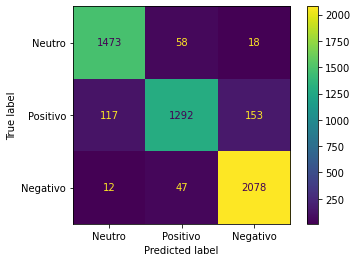

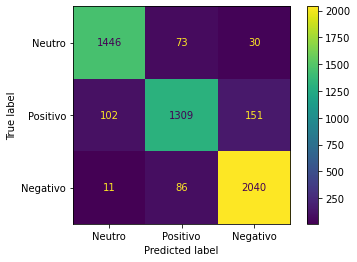

In [173]:
for key in dic_predicts.keys():    
    y_pred = dic_predicts[key]
    cm = metrics.confusion_matrix(y_test, y_pred)    
    cm_display = metrics.ConfusionMatrixDisplay(cm, display_labels=y_test.unique()).plot()

In [174]:
# Para caso onde os temos classficações não binarias é necessario utilizar certas manobras para conseguir obtermos a nossa
# curva ROC, uma dessas metodologias é comparar uma classe contra as outras, deixando elas binarias de certa forma
# Referencia: https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a

In [175]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = metrics.confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [176]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a treshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [177]:
def plot_roc_curve(tpr, fpr, scatter = True, ax = None, label_name = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
        
    sns.lineplot(x = fpr, y = tpr, ax = ax, legend="brief", label=label_name)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

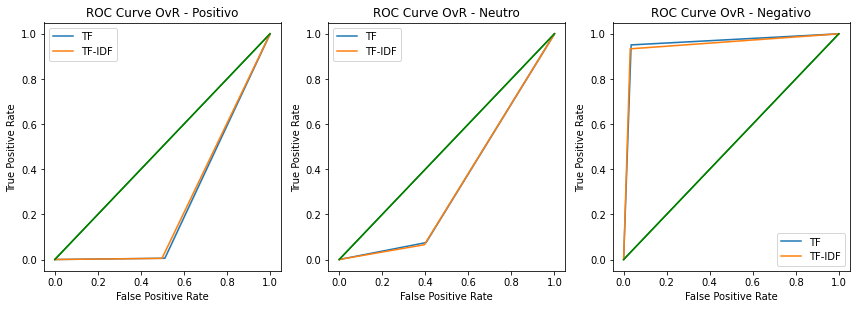

In [180]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
# Utilizando a metodologia OvR One vs Rest ou Um versus o resto

plt.figure(figsize = (12, 8))
classes =  twetter_df_clean.Classificacao.unique()
roc_auc_ovr = {}

# Calcula a curva ROC para cada tipo de calculo da bag of words
for key in dic_predicts_proba.keys():
  
  for i in range(len(classes)):
      # Recupera a classe
      classe = classes[i]
      
      # Verificar 
      list_class = [1 if y == classe else 0 for y in y_test]
      list_prob =  dic_predicts_proba[key][:, 0]
      data = {"class": list_class, "prob": list_prob}
      df_aux = pd.DataFrame(data)

      # Calculates the ROC Coordinates and plots the ROC Curves
      ax_bottom = plt.subplot(2, 3, i+4)
      tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
      plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom, label_name=key)
      ax_bottom.set_title(f"ROC Curve OvR - {classe}")

    # Calculates the ROC AUC OvR
      roc_auc_ovr[i] = metrics.roc_auc_score(df_aux['class'], df_aux['prob'])


plt.tight_layout()